In [1]:
!pip install -q finance-datareader

In [2]:
import os
import time

import pandas as pd
import FinanceDataReader as fdr
import datetime
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import argparse
from copy import deepcopy 
from sklearn.metrics import mean_absolute_error

import seaborn as sns 
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
def get_data(sym):
    file_path = "/content/gdrive/MyDrive/stockData/"
    csv_path = os.path.join(file_path, f"{sym}.csv")
    df = pd.read_csv(csv_path, parse_dates=True, index_col = ['Date'])
    return df

In [5]:
def Min_Max_Scaler(dataframe):
    d_min = np.min(dataframe, 0)
    d_max = np.max(dataframe, 0)

    numerator = dataframe - d_min
    denominator = d_max - d_min

    df = numerator / (denominator + 1e-7)


    return df

In [6]:
def return_data(data, data_min, data_max):
    return data * (data_max - data_min) + data_min

In [7]:
class StockDataset(Dataset):
    
    def __init__(self, data, x_frames, y_frames, start, end):
        self.x_frames = x_frames
        self.y_frames = y_frames

        self.start = start
        self.end = end

        self.data = data.loc[self.start : self.end]


    def __len__(self):
        return len(self.data) - (self.x_frames + self.y_frames) + 1
    
    def __getitem__(self, idx):
        idx += self.x_frames
        data = self.data.iloc[idx-self.x_frames:idx+self.y_frames]
        data = data[['Close','Open', 'High', 'Low', 'Volume', 'Change']]
        data = data.values
        X = data[:self.x_frames]
        y = data[self.x_frames:]
        
        return X, y

In [8]:
class LSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, batch_size, dropout, use_bn):
        super(LSTM, self).__init__()
        self.input_dim = input_dim 
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.batch_size = batch_size
        self.dropout = dropout
        self.use_bn = use_bn 
        
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.hidden = self.init_hidden()
        self.regressor = self.make_regressor()
        
    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
    
    def make_regressor(self):
        layers = []
        if self.use_bn:
            layers.append(nn.BatchNorm1d(self.hidden_dim))
        layers.append(nn.Dropout(self.dropout))
        
        layers.append(nn.Linear(self.hidden_dim, self.hidden_dim // 2))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hidden_dim // 2, self.output_dim))
        regressor = nn.Sequential(*layers)
        return regressor
    
    def forward(self, x):
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        y_pred = self.regressor(lstm_out[-1].view(self.batch_size, -1))
        return y_pred

In [9]:
def metric(y_pred, y_true):
    perc_y_pred = np.exp(y_pred.cpu().detach().numpy())
    perc_y_true = np.exp(y_true.cpu().detach().numpy())
    mae = mean_absolute_error(perc_y_true, perc_y_pred, multioutput='raw_values')
    return mae*100

In [38]:
class EarlyStopping:
    def __init__(self, args):
        self.patience = args.patience
        self.counter = 0
        self.best_score = None
        self.best_val_acc = None
        self.best_train_acc = None
        self.val_loss_min = np.Inf
        self.early_stop = False


        self.hash_key = hashlib.sha1(str(vars(args)).encode()).hexdigest()[:6]

        if not os.path.isdir(args.path):
            os.mkdir(args.path)

    def __call__(self, val_loss, val_acc, train_acc, model, optimizer):

        score = val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_val_acc = val_acc
            self.best_train_acc = train_acc
            
            print('Validation loss decreased ({:.4f} --> {:.4f}).  Saving model ...'.format(self.val_loss_min, val_loss))

            # torch.save(model.state_dict(), args.path+f'{args.exp_name}-{self.hash_key}-model.pt')

            torch.save({
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
            }, args.path+f'{args.exp_name}-{self.hash_key}-model.pt')

            self.val_loss_min = val_loss

        elif score > self.best_score:
            self.counter += 1
            print("EarlyStopping counter: {} out of {}".format(self.counter, self.patience))

            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self.best_val_acc = val_acc
            self.best_train_acc = train_acc

            self.counter = 0

            print('Validation loss decreased --- Saving model ...')

            # torch.save(model.state_dict(), args.path+f'{args.exp_name}-{self.hash_key}-model.pt')

            torch.save({
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
            },args.path+f'{args.exp_name}-{self.hash_key}-model.pt')

            self.val_loss_min = val_loss

In [11]:
def train(model, partition, optimizer, loss_fn, args):
    trainloader = DataLoader(partition['train'], 
                             batch_size=args.batch_size, 
                             shuffle=True, drop_last=True)

    model.train()
    model.zero_grad()
    optimizer.zero_grad()

    train_acc = 0.0
    train_loss = 0.0
    for i, (X, y) in enumerate(trainloader):

        X = X.to(args.device)
        y = y.to(args.device)

        X = X.transpose(0, 1).float()
        y_true = y[:, :, 0].float()
        
        model.zero_grad()
        optimizer.zero_grad()
        model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]


        y_pred = model(X)
        loss = loss_fn(y_pred.view(-1), y_true.view(-1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += metric(y_pred, y_true)[0]

    train_loss = train_loss / len(trainloader)
    train_acc = train_acc / len(trainloader)
    return model, train_loss, train_acc

In [12]:
def validate(model, partition, loss_fn, args):
    valloader = DataLoader(partition['val'], 
                           batch_size=args.batch_size, 
                           shuffle=False, drop_last=True)
    model.eval()

    val_acc = 0.0
    val_loss = 0.0
    with torch.no_grad():
        for i, (X, y) in enumerate(valloader):
            X = X.to(args.device)
            y = y.to(args.device)

            X = X.transpose(0, 1).float()
            y_true = y[:, :, 0].float()

            model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            y_pred = model(X)
    
            loss = loss_fn(y_pred.view(-1), y_true.view(-1))

            val_loss += loss.item()
            val_acc += metric(y_pred, y_true)[0]

    val_loss = val_loss / len(valloader)
    val_acc = val_acc / len(valloader)
    return val_loss, val_acc

In [46]:
def test(model, data, start, end, args):
    data_scaled = Min_Max_Scaler(data)

    testset = StockDataset(data_scaled, args.x_frames, args.y_frames, start, end)

    testloader = DataLoader(testset, 
                           batch_size=args.batch_size, 
                           shuffle=False, drop_last=True)
    
    test_t = data.loc[start:end]
    test_ind = test_t.index
    
    d_min = np.min(data, 0)
    d_max = np.max(data, 0)

    model.to(args.device)
    model.eval()    

    test_acc = 0.0
    prediction = []
    with torch.no_grad():
        for i, (X, y) in enumerate(testloader):
            X = X.to(args.device)
            y = y.to(args.device)

            X = X.transpose(0, 1).float()
            y_true = y[:, :, 0].float()
            
            model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            y_pred = model(X)
            test_acc += metric(y_pred, y_true)[0]

            temp = []
            y = y_pred.cpu().detach().numpy()

            for i in range(len(y)):
                temp.append(y[i].item())

            prediction = prediction + temp


    test_acc = test_acc / len(testloader)

    len_pred = len(prediction)
    len_ind = len(test_ind)

    temp_ind = len_pred - len_ind
    ind = test_ind[:temp_ind]

    test_df = pd.DataFrame({"Close": prediction}, index=ind)
    test_df = return_data(test_df, d_min[0], d_max[0])

    true_y = data.loc[ind[0]:ind[-1]]['Close']

    return test_df, pd.DataFrame(true_y)

In [39]:
def experiment(partition, args, load = False):
    hash_key = hashlib.sha1(str(vars(args)).encode()).hexdigest()[:6]

    model = LSTM(args.input_dim, args.hid_dim, args.y_frames, args.n_layers, args.batch_size, args.dropout, args.use_bn)
    loss_fn = nn.MSELoss()
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice. Choose one of SGD, RMSprop, Adam')

    if load:
        load_hash = input("Enter the Hash Key: ")
        model, optimizer = load_model(args, load_hash)
        for state in optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.cuda()
        



    model.to(args.device)

    
    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # ===================================== #
    
    early_stopping = EarlyStopping(args)

    for epoch in range(args.epoch):  # loop over the dataset multiple times
        
        start = time.time()
        model, train_loss, train_acc = train(model, partition, optimizer, loss_fn, args)
        val_loss, val_acc = validate(model, partition, loss_fn, args)
        end = time.time()

        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.5f}/{:2.5f}. Took {:2.2f} sec'.format(epoch+1, train_acc, val_acc, train_loss, val_loss, end-start))

        early_stopping(val_loss, val_acc, train_acc, model, optimizer)

        if early_stopping.early_stop:
            print("Early Stopping!!")
            val_loss = early_stopping.val_loss_min
            val_acc = early_stopping.best_val_acc
            train_acc = early_stopping.best_train_acc
            end = time.time()
            break
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #


    model = load_model(args)
    

    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = [x for x in train_losses]
    result['val_losses'] = [x for x in val_losses]
    result['train_accs'] = [x for x in train_accs]
    result['val_accs'] = [x for x in val_accs]
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    
    return model[0], vars(args), result

In [40]:
def load_model(args, load_hash = None):
    if load_hash is None:
        hash_key = hashlib.sha1(str(vars(args)).encode()).hexdigest()[:6]
    else:
        hash_key = load_hash

    model = LSTM(args.input_dim, args.hid_dim, args.y_frames, args.n_layers, args.batch_size, args.dropout, args.use_bn)
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)

    checkpoint = torch.load(args.path+f'{args.exp_name}-{hash_key}-model.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


    return model, optimizer

In [41]:
import hashlib
import json
from os import listdir
from os.path import isfile, join


def save_exp_result(setting, result):
    exp_name = setting['exp_name']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    
    filepath = '/content/gdrive/MyDrive/results'
    if not os.path.isdir(filepath):
        os.mkdir(filepath)

    filename = '/content/gdrive/MyDrive/results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = '/content/gdrive/MyDrive/results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result)
    return df

In [53]:
# ====== Random Seed Initialization ====== #
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_lr"
args.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

print(args.device)

# ====== Data Loading ====== #
args.symbol = 'AAPL'
args.batch_size = 16
args.x_frames = 5
args.y_frames = 1

df = get_data(args.symbol)
df_scaled = Min_Max_Scaler(df)

trainset = StockDataset(df_scaled, args.x_frames, args.y_frames, '2000-01-01', '2018-01-01')
valset = StockDataset(df_scaled, args.x_frames, args.y_frames, '2018-01-01', '2019-01-01')

partition = {'train': trainset, 'val':valset}

cuda:0


In [54]:
# ====== Model Capacity ===== #
args.input_dim = 6
args.hid_dim = 50
args.n_layers = 1

# ====== Regularization ======= #
args.l2 = 0.0001
args.dropout = 0.3
args.use_bn = True

# ====== Optimizer & Training ====== #
args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0001
args.epoch = 200
args.patience = 20
args.path = '/content/gdrive/MyDrive/model_checkpoint/'

In [55]:
# ====== Experiment Variable ====== #
name_var1 = 'lr'
name_var2 = 'n_layers'
list_var1 = [0.001, 0.0001]
list_var2 = [1,2]

model_dict = {}

for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        model, setting, result = experiment(partition, deepcopy(args))
        hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
        model_dict[hash_key] = model
        save_exp_result(setting, result)

Namespace(batch_size=16, device='cuda:0', dropout=0.3, epoch=200, exp_name='exp1_lr', hid_dim=50, input_dim=6, l2=0.0001, lr=0.001, n_layers=1, optim='Adam', path='/content/gdrive/MyDrive/model_checkpoint/', patience=20, symbol='AAPL', use_bn=True, x_frames=5, y_frames=1)


KeyboardInterrupt: ignored

In [19]:
def plot_acc(var1, var2, df):

    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(15, 6)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.barplot(x=var1, y='train_acc', hue=var2, data=df, ax=ax[0])
    sns.barplot(x=var1, y='val_acc', hue=var2, data=df, ax=ax[1])

    
    ax[0].set_title('Train Accuracy')
    ax[1].set_title('Validation Accuracy')

In [20]:
def plot_loss_variation(var1, var2, df, **kwargs):

    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_losses = list(row.train_losses)[0]
            val_losses = list(row.val_losses)[0]

            for epoch, train_loss in enumerate(train_losses):
                list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_loss in enumerate(val_losses):
                list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.89)

In [21]:
var1 = 'lr'
var2 = 'n_layers'
df_result = load_exp_result('exp1')

In [22]:
df_result

,train_losses,val_losses,train_accs,val_accs,train_acc,val_acc,exp_name,device,symbol,batch_size,x_frames,y_frames,input_dim,hid_dim,n_layers,l2,dropout,use_bn,optim,lr,epoch,patience,path
0,"[0.005668148706053674, 0.0010110088674114613, ...","[0.0027141566233088573, 0.00047844032427140823...","[5.908728007306444, 2.6677845970113228, 2.1993...","[7.015950775146484, 2.761241841316223, 1.69670...",2.014199,0.826209,exp1_lr,cuda:0,AAPL,16,5,1,6,50,1,0.0001,0.3,True,Adam,0.0010,200,20,/content/gdrive/MyDrive/model_checkpoint/
1,"[0.0011845393308262087, 0.00042601644269670425...","[0.0030089863110333683, 0.00024302205832403464...","[2.667333282054739, 1.723513828735825, 1.84818...","[7.483546861012777, 1.9253268718719483, 1.0843...",1.757636,0.967930,exp1_lr,cuda:0,AAPL,16,5,1,6,50,2,0.0001,0.3,True,Adam,0.0010,200,20,/content/gdrive/MyDrive/model_checkpoint/
2,"[0.019090724787806948, 0.0077377025022316755, ...","[0.022238855498532453, 0.00260712505163004, 0....","[11.679475630428774, 7.365991731062003, 5.9259...","[19.373072878519693, 6.838226413726806, 9.4859...",2.100400,0.670883,exp1_lr,cuda:0,AAPL,16,5,1,6,50,1,0.0001,0.3,True,Adam,0.0001,200,20,/content/gdrive/MyDrive/model_checkpoint/
3,"[0.020717852255197386, 0.007721530166223434, 0...","[0.0693231150507927, 0.025519286344448725, 0.0...","[11.79304365908846, 7.41880986369248, 5.935372...","[42.47911122639974, 24.160470898946127, 19.205...",3.219506,0.989862,exp1_lr,cuda:0,AAPL,16,5,1,6,50,2,0.0001,0.3,True,Adam,0.0001,200,20,/content/gdrive/MyDrive/model_checkpoint/


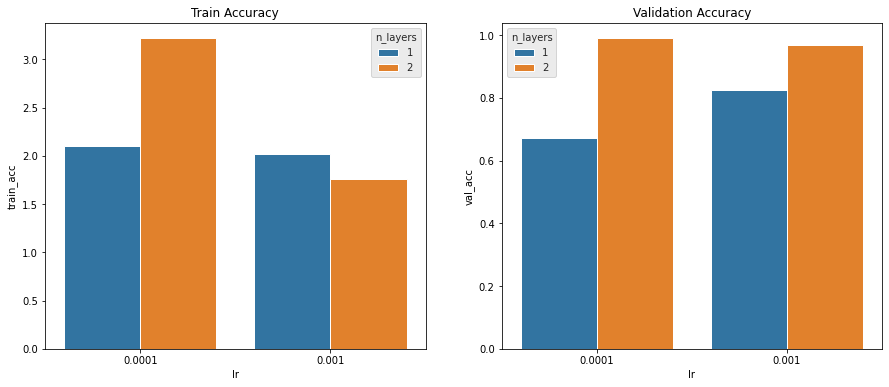

In [105]:
plot_acc(var1, var2, df_result)

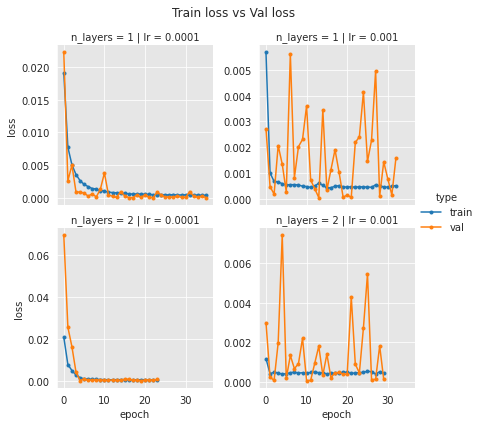

In [106]:
plot_loss_variation(var1, var2, df_result, sharey=False)

In [23]:
args.lr = 0.0001
args.n_layers = 1
hash_key = hashlib.sha1(str(vars(args)).encode()).hexdigest()[:6]

In [24]:
hash_key

'eec202'

In [56]:
# ====== Data Loading ====== #
args.symbol = 'GOOGL'
args.batch_size = 16
args.x_frames = 5
args.y_frames = 1

df = get_data(args.symbol)
df_scaled = Min_Max_Scaler(df)

trainset = StockDataset(df_scaled, args.x_frames, args.y_frames, '2000-01-01', '2018-01-01')
valset = StockDataset(df_scaled, args.x_frames, args.y_frames, '2018-01-01', '2019-01-01')

partition = {'train': trainset, 'val':valset}

In [43]:
model, setting, result = experiment(partition, deepcopy(args), load = True)

Enter the Hash Key: eec202
Epoch 1, Acc(train/val): 5.47/4.94, Loss(train/val) 0.00323/0.00090. Took 4.25 sec
Validation loss decreased (inf --> 0.0009).  Saving model ...
Epoch 2, Acc(train/val): 4.25/14.44, Loss(train/val) 0.00195/0.00600. Took 4.25 sec
EarlyStopping counter: 1 out of 20
Epoch 3, Acc(train/val): 4.10/3.99, Loss(train/val) 0.00180/0.00062. Took 4.16 sec
Validation loss decreased --- Saving model ...
Epoch 4, Acc(train/val): 3.85/11.17, Loss(train/val) 0.00165/0.00374. Took 4.25 sec
EarlyStopping counter: 1 out of 20
Epoch 5, Acc(train/val): 3.71/4.89, Loss(train/val) 0.00146/0.00088. Took 4.27 sec
EarlyStopping counter: 2 out of 20
Epoch 6, Acc(train/val): 3.75/4.87, Loss(train/val) 0.00150/0.00084. Took 4.14 sec
EarlyStopping counter: 3 out of 20
Epoch 7, Acc(train/val): 3.59/4.71, Loss(train/val) 0.00139/0.00081. Took 4.16 sec
EarlyStopping counter: 4 out of 20
Epoch 8, Acc(train/val): 3.59/2.40, Loss(train/val) 0.00139/0.00028. Took 4.17 sec
Validation loss decreas

In [44]:
hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
hash_key

'bed449'

In [47]:
test_y, true_y = test(model, df, '2020-01-01', '2020-12-24', args)

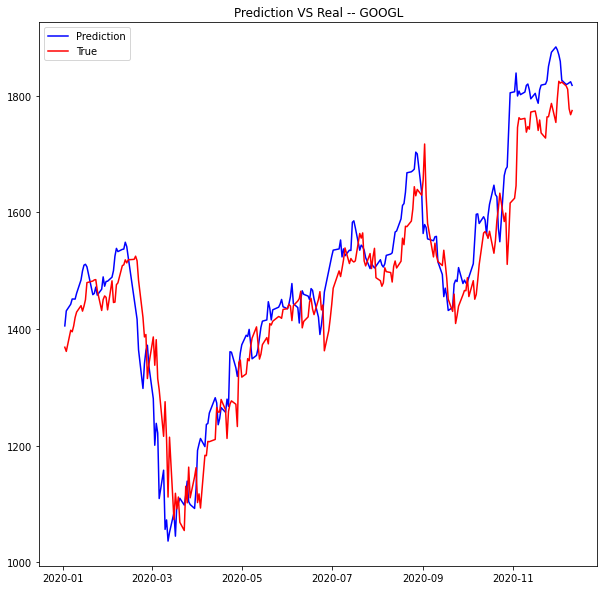

In [48]:
plt.figure(figsize=(10,10))
plt.title("Prediction VS Real -- GOOGL")
plt.plot(test_y, color='b')
plt.plot(true_y, color='r')
plt.legend(["Prediction", "True"],loc='upper left')

In [49]:
df2 = get_data('AMZN')
df2_scaled = Min_Max_Scaler(df2)
test_y2, true_y2 = test(model, df2, '2020-01-01', '2020-12-24', args)

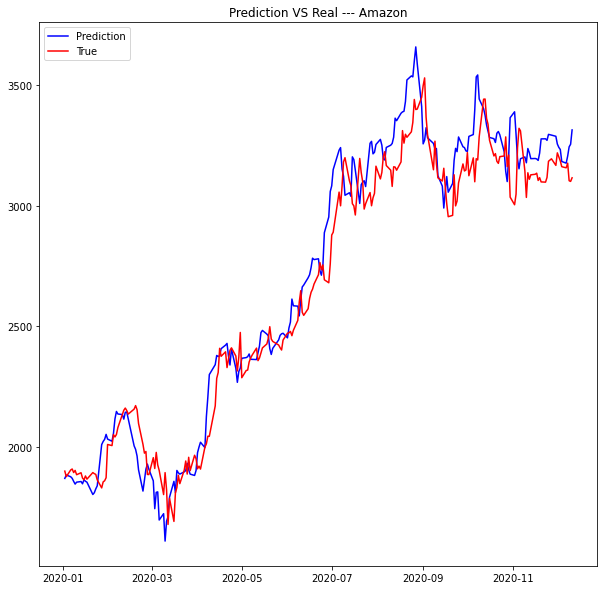

In [50]:
plt.figure(figsize=(10,10))
plt.title("Prediction VS Real --- Amazon")
plt.plot(test_y2, color='b')
plt.plot(true_y2, color='r')
plt.legend(["Prediction", "True"],loc='upper left')

In [51]:
mean_absolute_error(test_y, true_y)

50.700119083692634

In [52]:
mean_absolute_error(test_y2, true_y2)

99.44827824962132

In [57]:
model2, setting, result = experiment(partition, deepcopy(args))

Epoch 1, Acc(train/val): 11.44/17.69, Loss(train/val) 0.01543/0.00971. Took 4.17 sec
Validation loss decreased (inf --> 0.0097).  Saving model ...
Epoch 2, Acc(train/val): 6.68/5.53, Loss(train/val) 0.00482/0.00127. Took 4.15 sec
Validation loss decreased --- Saving model ...
Epoch 3, Acc(train/val): 4.70/5.34, Loss(train/val) 0.00233/0.00102. Took 4.21 sec
Validation loss decreased --- Saving model ...
Epoch 4, Acc(train/val): 4.41/1.98, Loss(train/val) 0.00216/0.00019. Took 4.25 sec
Validation loss decreased --- Saving model ...
Epoch 5, Acc(train/val): 4.19/11.20, Loss(train/val) 0.00182/0.00370. Took 4.22 sec
EarlyStopping counter: 1 out of 20
Epoch 6, Acc(train/val): 3.86/4.35, Loss(train/val) 0.00157/0.00069. Took 4.18 sec
EarlyStopping counter: 2 out of 20
Epoch 7, Acc(train/val): 3.86/21.00, Loss(train/val) 0.00156/0.01193. Took 4.17 sec
EarlyStopping counter: 3 out of 20
Epoch 8, Acc(train/val): 3.52/3.16, Loss(train/val) 0.00129/0.00047. Took 4.22 sec
EarlyStopping counter: 4

In [58]:
test_y, true_y = test(model2, df, '2020-01-01', '2020-12-24', args)

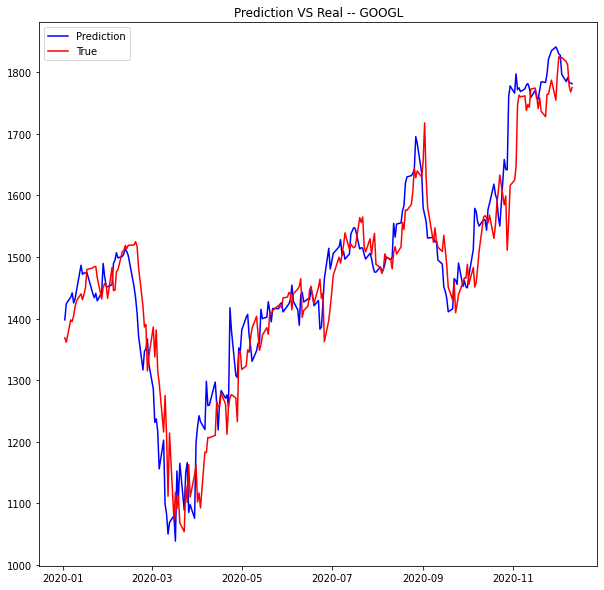

In [59]:
plt.figure(figsize=(10,10))
plt.title("Prediction VS Real -- GOOGL")
plt.plot(test_y, color='b')
plt.plot(true_y, color='r')
plt.legend(["Prediction", "True"],loc='upper left')

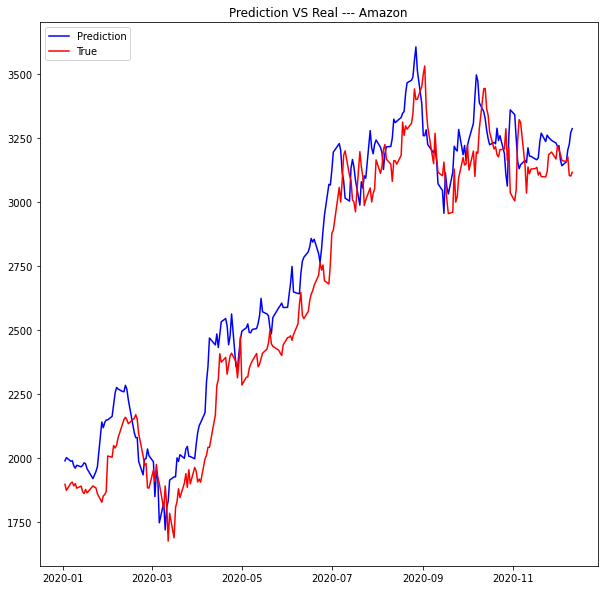

In [63]:
test_y2, true_y2 = test(model2, df2, '2020-01-01', '2020-12-24', args)
plt.figure(figsize=(10,10))
plt.title("Prediction VS Real --- Amazon")
plt.plot(test_y2, color='b')
plt.plot(true_y2, color='r')
plt.legend(["Prediction", "True"],loc='upper left')

In [64]:
mean_absolute_error(test_y, true_y)

42.14254925817251

In [65]:
mean_absolute_error(test_y2, true_y2)

126.94643866973114

* 기존에 학습한 모델을 다시 불러와서 학습한것 model1
* 새 모델에 학습 시킨것 model2

* model2가 성능 약간 더 좋음
* 근데 완전 새로운 종목에 대해 예측할때는 model1이 낫지만 둘 다 완전 별로